# **OpenFoodFact**

**Questions I would like to ask**

1. **NOVA-grade** (processing level of food) - Common ingredients/food that are classified as most processed

2. **Nutrition-grade** - Is the food really nutritious as its label mentions?

3. How to choose similar products to my favorite one?



# A. IMPORT


In [ ]:
import pandas as pd, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import joblib
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import scatter_matrix
pd.set_option('max_colwidth', 20000)
import re
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, make_scorer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#B. EXPLORING DATA

###I. Get the Data

In [ ]:
rawdata = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Data/en.openfoodfacts.org.products.csv', sep='\t')

In [ ]:
rawdata.head(4)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,"Leche semidesnatada, azucar 6.9% leche desnata...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rawdata.shape

(1977215, 186)

#### Take a Quick Look at the Data

In [ ]:
def nova_count_each_country(n):
  """
  Function to plot top n countries with non-null counts of nova_grade 
  """
  # Get top n countries with highest number of Non-missing values for Nova_group
  nova_notna = rawdata[rawdata['nova_group'].notna()]
  plot_countries = nova_notna[['countries','nova_group']].groupby('countries').count().sort_values('nova_group',ascending=False).head(n)
  plot_countries.reset_index(inplace=True)
  # plot
  plt.figure(figsize = (12,5))
  sns.barplot(data=plot_countries, x='countries',y='nova_group')
  plt.show()

In [ ]:
def nutri_count_each_country(n):
  """
  Function to plot top n countries with non-null counts of nova_grade 
  """
  # Get top n countries with highest number of Non-missing values for nutriscore_grade
  nutri_notna = rawdata[rawdata['nutriscore_grade'].notna()]
  plot_countries = nutri_notna[['countries','nutriscore_grade']].groupby('countries').count().sort_values('nutriscore_grade',ascending=False).head(n)
  plot_countries.reset_index(inplace=True)
  # plot
  plt.figure(figsize = (12,5))
  sns.barplot(data=plot_countries, x='countries',y='nutriscore_grade')
  plt.show()

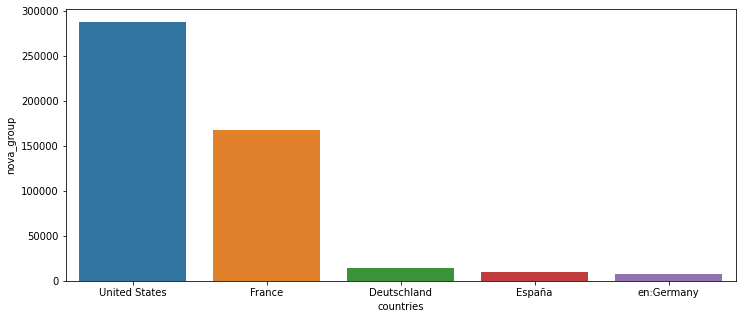

In [ ]:
nova_count_each_country(5)

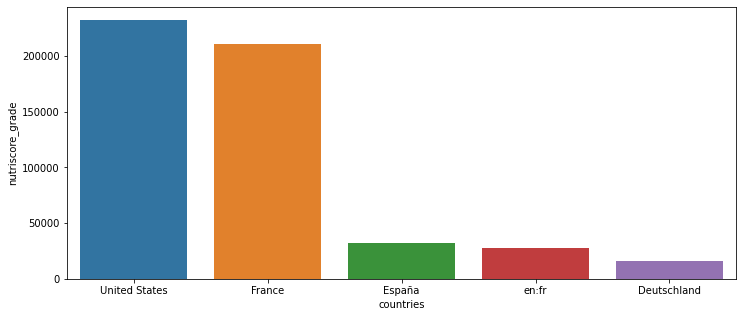

In [ ]:
nutri_count_each_country(5)

**Comment**: United States has the most prominent number of non-missing values in **NOVA_group** and **Nutri_grade** columns for ML pipeline, I will filter out only products from United States origin, also for analyzing their ingredients later

In [ ]:
# only select products from US
data = rawdata[rawdata['countries'].isin(['United States','US','USA'])]
data.loc[data.countries=="US","countries"] = "United States"
data.loc[data.countries=="USA","countries"] = "United States"

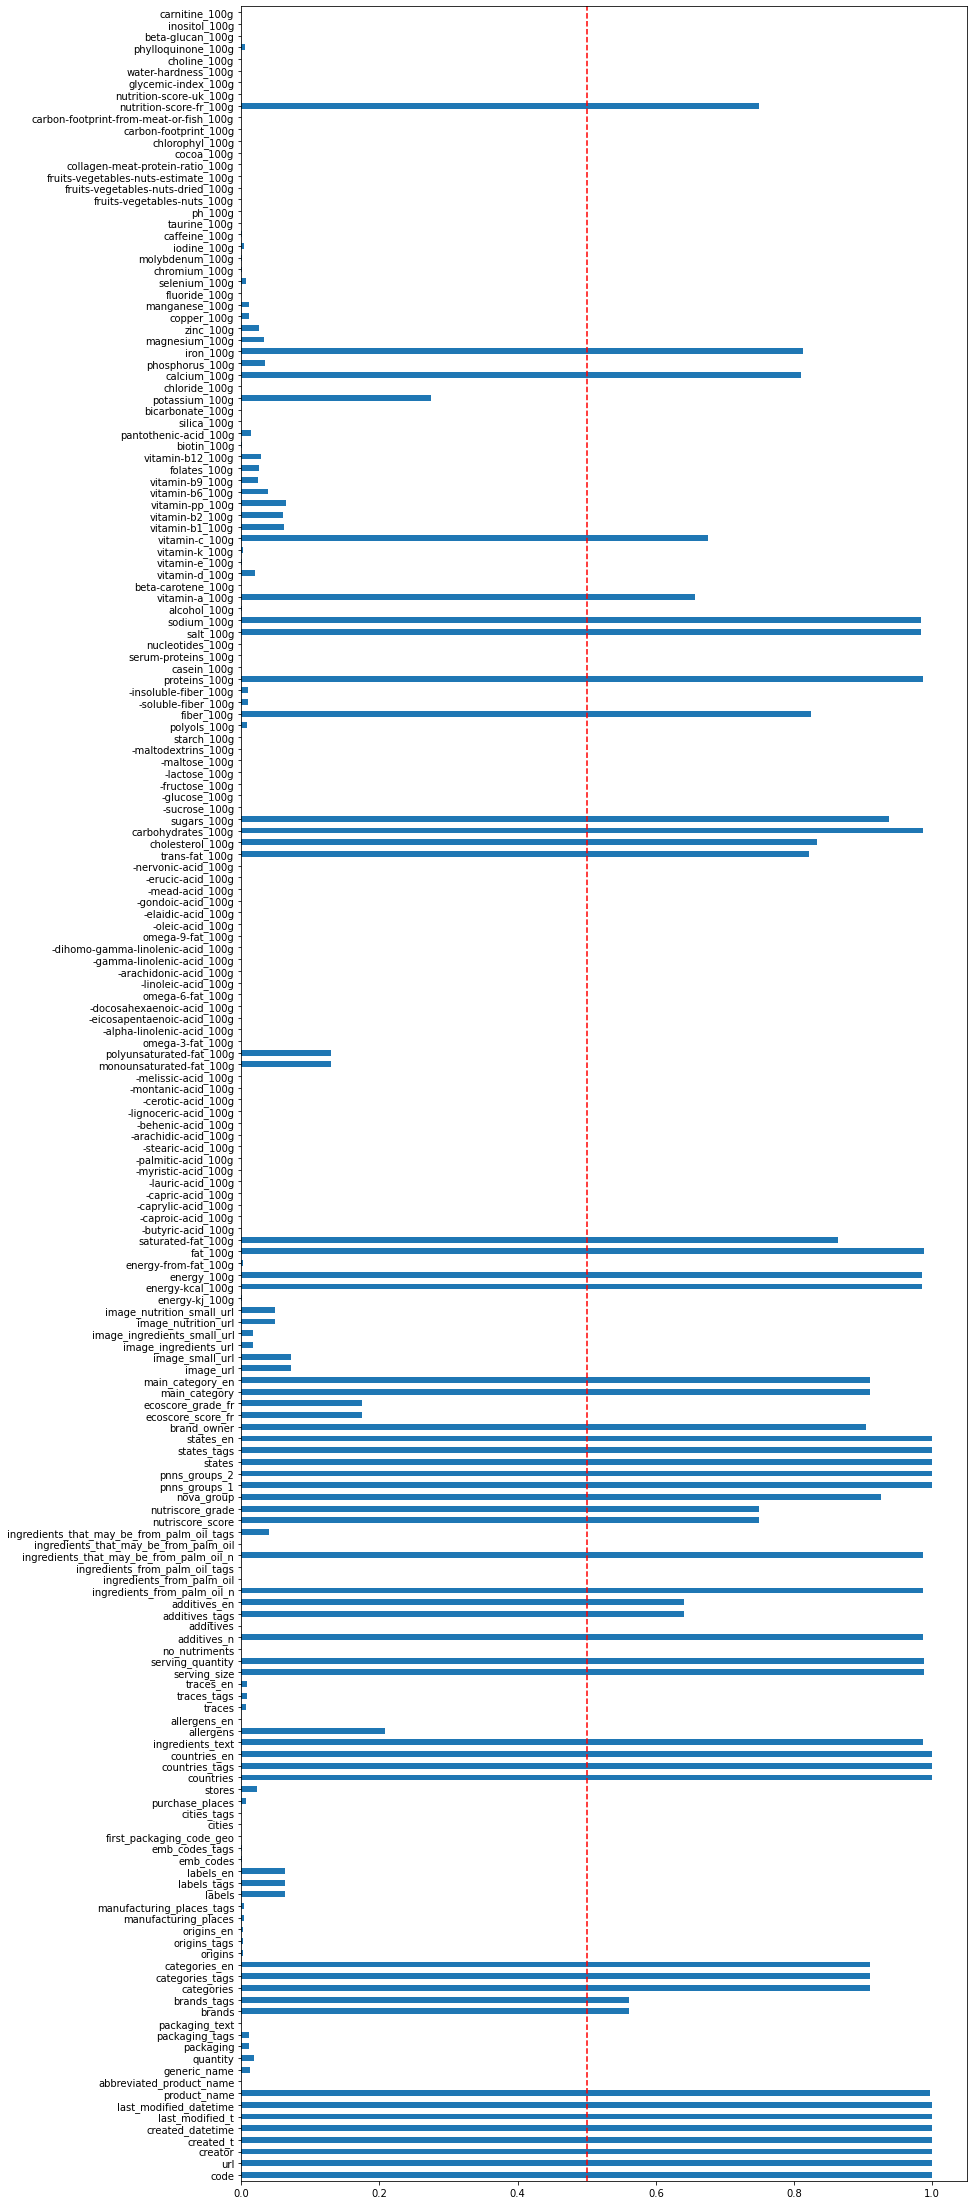

In [ ]:
plt.figure(figsize=(13, 40))
data.notnull().mean(axis=0).plot(kind='barh')
plt.axvline(x=0.5, linestyle='--', color='red')
plt.show()

##**II. Preprocessing the Data**

#### Filtering columns and duplications

Any duplications in the data will be removed

In [ ]:
data = data[~data['code'].duplicated()]
data = data
dup = data.duplicated().sum()
print(f"There's {dup} duplication(s) in the data")

There's 0 duplication(s) in the data


Now only the features that are common in a Nutrition Fact of a food package are selected. Some columns are renamed for better understanding

In [ ]:
cols_to_keep = ["product_name","url","ingredients_text","main_category_en","labels_en","countries_en",
                "nutriscore_score","nutriscore_grade", "nova_group",
                "cholesterol_100g","fat_100g","sodium_100g", "sugars_100g","carbohydrates_100g",
                "proteins_100g", "saturated-fat_100g", "fiber_100g","trans-fat_100g",
                "energy-kcal_100g",
                "additives_en"]

# filter out data with only columns to keep                
data = data[cols_to_keep]

data = data.rename(columns={"ingredients_text":"Ingredients", "product_name":"Name",
                            "main_category_en":"Category",
                            "labels_en":"Label", 'countries_en':"Countries",
                            "nutriscore_score":"nutri_score",
                            "nutriscore_grade": "nutri_grade",
                            "nova_group": "nova_grade",
                            "cholesterol_100g":"Cholesterol",
                            "trans-fat_100g":"Trans fat",
                            "fiber_100g": "Fiber",
                            "fat_100g":"Fat",
                            "saturated-fat_100g":"Saturated fat",
                            "carbohydrates_100g":"Carbohydrates",
                            "proteins_100g":"Protein",
                            "sodium_100g":"Sodium",
                            "sugars_100g":"Sugars",
                            "energy-kcal_100g": "Energy_kcal",
                            "additives_en": "additives",
                            })

In [ ]:
data.head(3)

,product_name,url,nutri_grade,nutri_score,nova_grade,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Energy_kcal,additives
59,Banana Chips Sweetened (Whole),http://world-en.openfoodfacts.org/product/0000000004530/banana-chips-sweetened-whole,NaN,NaN,4.0,0.018,28.57,0.000000,14.29,64.29,3.57,28.57,3.6,536.0,NaN
60,Peanuts,http://world-en.openfoodfacts.org/product/0000000004559/peanuts-torn-glasser,NaN,NaN,NaN,0.000,17.86,0.254000,17.86,60.71,17.86,0.00,7.1,464.0,"E500 - Sodium carbonates,E500ii - Sodium hydrogen carbonate,E503 - Ammonium carbonates,E503ii - Ammonium hydrogen carbonate"
119,Organic Salted Nut Mix,http://world-en.openfoodfacts.org/product/0000000016087/organic-salted-nut-mix-grizzlies,NaN,NaN,NaN,NaN,57.14,0.489712,3.57,17.86,17.86,5.36,7.1,607.0,NaN


### Handling missing values

####Categorical features

Check the missing values count of each column 

In [ ]:
print(f"Missing values in each column:")
print(data.isna().sum())
print('\n',f"Data consists of total {len(data)} products")

Missing values in each column:
Name                889
url                   0
Ingredients        4208
Category          28045
Label            290936
Countries             0
nutri_score       77934
nutri_grade       77934
nova_grade        22767
Cholesterol       51511
Fat                3707
Sodium             5136
Sugars            19402
Carbohydrates      4040
Protein            4138
Saturated fat     42230
Fiber             54547
Trans fat         55363
Energy_kcal        4400
additives        111313
dtype: int64

 Data consists of total 310345 products


Product_name has some missing values, for which will be filled in "Unknown"

In [ ]:
# fill 'Unknown' for missing values in Name and Label
data['Name'] = data['Name'].fillna('Unknown')
data["Label"] = data["Label"].fillna("Unknown")
data["Countries"] = data['Countries'].fillna("Unknown")
# Check again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310345 entries, 59 to 1977165
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Name           310345 non-null  object 
 1   url            310345 non-null  object 
 2   Ingredients    306137 non-null  object 
 3   Category       282300 non-null  object 
 4   Label          310345 non-null  object 
 5   Countries      310345 non-null  object 
 6   nutri_score    232411 non-null  float64
 7   nutri_grade    232411 non-null  object 
 8   nova_grade     287578 non-null  float64
 9   Cholesterol    258834 non-null  float64
 10  Fat            306638 non-null  float64
 11  Sodium         305209 non-null  float64
 12  Sugars         290943 non-null  float64
 13  Carbohydrates  306305 non-null  float64
 14  Protein        306207 non-null  float64
 15  Saturated fat  268115 non-null  float64
 16  Fiber          255798 non-null  float64
 17  Trans fat      254982 non-n

In [ ]:
# 1 - has additives / 0 - no additives
def check_additives(row):
  if pd.isna(row):
    return 0
  else:
    return len(row.split(','))

In [ ]:
data['Additives_count'] = data['additives'].apply(check_additives)
data["additives"] = data['additives'].fillna("Unknown")
data.head(2)

,Name,url,Ingredients,Category,Label,Countries,nutri_score,nutri_grade,nova_grade,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Trans fat,Energy_kcal,additives,Additives_count
59,Banana Chips Sweetened (Whole),http://world-en.openfoodfacts.org/product/0000000004530/banana-chips-sweetened-whole,"Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.",NaN,Unknown,United States,NaN,NaN,4.0,0.018,28.57,0.000,14.29,64.29,3.57,28.57,3.6,0.0,536.0,Unknown,0
60,Peanuts,http://world-en.openfoodfacts.org/product/0000000004559/peanuts-torn-glasser,"Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.",NaN,Unknown,United States,NaN,NaN,NaN,0.000,17.86,0.254,17.86,60.71,17.86,0.00,7.1,0.0,464.0,"E500 - Sodium carbonates,E500ii - Sodium hydrogen carbonate,E503 - Ammonium carbonates,E503ii - Ammonium hydrogen carbonate",4


####Numerical features

###Filling in missing values for Recommendation

Select products with missing Nova and Nutril labels to fill in using ML models that I will be building later. The purpose of this approach is to increase the number of products available for recommending to users

In [ ]:
m = data[(data.Category.notna()) & (data.Label.notna()) & (data.Ingredients.notna()) & (data.Cholesterol.notna()) & (data.Sodium.notna()) & (data.Sugars.notna()) &(data["Trans fat"].notna()) & (data.Fat.notna()) & (data.Carbohydrates.notna()) & (data.Protein.notna()) & (data["Saturated fat"].notna()) & (data.Fiber.notna())  & (data.Energy_kcal.notna())]
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220396 entries, 286 to 1976960
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             220396 non-null  object 
 1   url              220396 non-null  object 
 2   Ingredients      220396 non-null  object 
 3   Category         220396 non-null  object 
 4   Label            220396 non-null  object 
 5   Countries        220396 non-null  object 
 6   nutri_score      215733 non-null  float64
 7   nutri_grade      215733 non-null  object 
 8   nova_grade       214468 non-null  float64
 9   Cholesterol      220396 non-null  float64
 10  Fat              220396 non-null  float64
 11  Sodium           220396 non-null  float64
 12  Sugars           220396 non-null  float64
 13  Carbohydrates    220396 non-null  float64
 14  Protein          220396 non-null  float64
 15  Saturated fat    220396 non-null  float64
 16  Fiber            220396 non-null  f

This subset of data will be used only for Recommendation system

#####Drop missing values

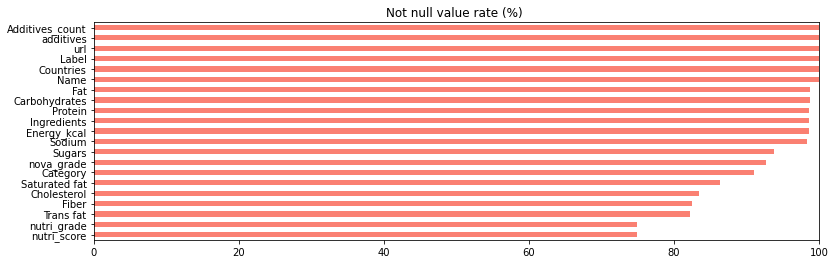

In [ ]:
plt.figure(figsize=(13,4))
(data.notnull().mean(axis=0)*100).sort_values().plot.barh(color ="salmon")
plt.xlim(xmax=100)
plt.title("Not null value rate (%) ")
plt.show()

**Comments:** Some nutrient columns have around 10-25% missing values. Due to the nature of nutrition values in food products, Imputation using Mean/median is not very appropriate, therefore all remaining missing values will be dropped


In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209958 entries, 286 to 1976960
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             209958 non-null  object 
 1   url              209958 non-null  object 
 2   Ingredients      209958 non-null  object 
 3   Category         209958 non-null  object 
 4   Label            209958 non-null  object 
 5   Countries        209958 non-null  object 
 6   nutri_score      209958 non-null  float64
 7   nutri_grade      209958 non-null  object 
 8   nova_grade       209958 non-null  float64
 9   Cholesterol      209958 non-null  float64
 10  Fat              209958 non-null  float64
 11  Sodium           209958 non-null  float64
 12  Sugars           209958 non-null  float64
 13  Carbohydrates    209958 non-null  float64
 14  Protein          209958 non-null  float64
 15  Saturated fat    209958 non-null  float64
 16  Fiber            209958 non-null  f

### Outliers Treatment

In [ ]:
tmp = data.drop(columns=["Name","url","Ingredients","Category","Label","Countries","additives","Additives_count","nova_grade","nutri_grade","nutri_score"])

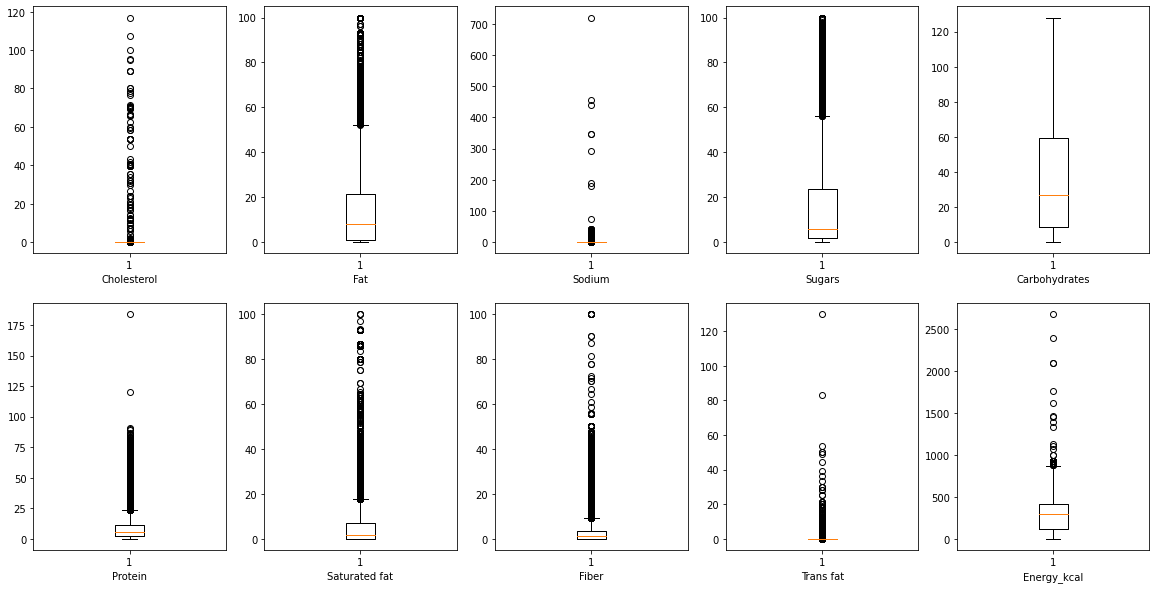

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))
for count, item in enumerate(ax.reshape(-1)):
  item.boxplot(tmp[tmp.columns[count]])

for i in range(2):
  for j in range(5):
    if i == 0:
      ax[i][j].set_xlabel(tmp.columns[j])
    else:
      ax[i][j].set_xlabel(tmp.columns[j+5])

plt.show()

In [ ]:
data.describe()

,nutri_score,nova_grade,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Trans fat,Energy_kcal,Additives_count
count,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000
mean,9.263724,3.430248,0.035975,13.323059,0.496505,14.988734,34.440099,7.973071,4.713527,2.674042,0.034629,285.081161,3.326646
std,9.081380,0.957082,1.063703,15.216983,2.856438,18.989295,27.643219,8.285883,6.708760,4.102146,0.626976,176.706587,4.300508
min,-14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,0.000000,0.910000,0.062000,1.690000,8.770000,2.380000,0.000000,0.000000,0.000000,115.000000,0.000000
50%,11.000000,4.000000,0.000000,8.240000,0.296000,5.710000,26.920000,5.640000,1.810000,1.400000,0.000000,292.000000,2.000000
75%,16.000000,4.000000,0.022000,21.430000,0.567000,23.530000,59.380000,10.830000,7.140000,3.600000,0.000000,417.000000,5.000000
max,40.000000,4.000000,116.915000,100.000000,719.666328,100.000000,128.000000,184.000000,100.000000,100.000000,130.000000,2674.000000,42.000000


Filter out outliers

In [ ]:
# data = data[data["Fat"]<50]
# data = data[data["Cholesterol"]<10]
# data = data[(data["Sodium"]<50)]
# data = data[(data["Sugars"]<60)]
# data = data[(data["Saturated fat"]<30)]
# data = data[(data["Trans fat"]<20)]
# data = data[(data["Fiber"]<10)]
# data = data[(data["Energy_kcal"]<1000)]
# data = data[data.Protein<30]
# len(data)

In [ ]:
# def removeOutliers(data):
#     for column in data:
#         q = data[column].quantile(0.99)
#         data=data[data[column] < q]
#     return data

In [ ]:
q_fat = data.Fat.quantile(0.99)
data = data[data["Fat"]<q_fat]
q_chol = data.Cholesterol.quantile(0.99)
data = data[data["Cholesterol"]<q_chol]
q_sod = data.Sodium.quantile(0.99)
data = data[(data["Sodium"]<q_sod)]
q_sug = data.Sugars.quantile(0.99)
data = data[(data["Sugars"]<q_sug)]
q_sat = data["Saturated fat"].quantile(0.99)
data = data[(data["Saturated fat"]< q_sat)]
q_trans = data["Trans fat"].quantile(0.99)
data = data[(data["Trans fat"]<q_trans)]
q_fib = data["Fiber"].quantile(0.99)
data = data[(data["Fiber"]<q_fib)]
q_ene = data.Energy_kcal.quantile(0.99)
data = data[(data["Energy_kcal"]<q_ene)]
q_pro = data["Protein"].quantile(0.99)
data = data[data.Protein<q_pro]

In [ ]:
data.iloc[:,9:19].describe()

,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Trans fat,Energy_kcal
count,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000
mean,0.016041,12.004346,0.380707,14.446214,34.280551,7.400758,4.281046,2.379596,0.002621,270.823775
std,0.027430,12.828051,0.402094,17.562855,27.248067,6.994074,5.618543,3.028119,0.030672,168.061100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.890000,0.064000,1.770000,8.800000,2.420000,0.000000,0.000000,0.000000,106.000000
50%,0.000000,7.550000,0.297000,5.880000,26.870000,5.405405,1.790000,1.400000,0.000000,275.000000
75%,0.021000,20.000000,0.550000,23.330000,59.150000,10.530000,6.670000,3.600000,0.000000,400.000000
max,0.126000,64.285714,3.323000,74.800000,100.000000,35.709998,24.730000,18.100000,0.580000,606.060606


###Categorization & Labeling

####Categorize the products

The Category columns contains a lot of overlapping information such that some products that should have belonged to 1 category were categorized into different ones with similar categories names. I will re-categorize the products into some most common categories:
- Plant-protein/Plant-based-foods
- Meat
- Seafood
- Eggs
- Dairy
- Grain
- Legumes
- Vegetables
- Fruits
etc.

In [ ]:
data.loc[(data.Name.str.contains(r"plant-based|vegetarian|meatless|tofu|vegetarian sausages", flags=re.IGNORECASE, regex=True)) & (data.Category.str.contains(r"Meat", flags=re.IGNORECASE, regex=True)), "Category"] = "Plant-protein"
data.loc[data.Name.str.contains(r"Vegan egg", flags=re.IGNORECASE, regex=True),"Label"] = "Vegan"
data.loc[data.Category.str.contains(r"(plant-based foods|frozen foods|frozen vegetables|frozen blueberries)", regex=True), "Category"] = "plant-based-foods"
data.loc[data.Category.str.contains(r"(fruits and vegetables based foods|fruits based foods)", regex=True), "Category"] = "plant-based-foods"
data.loc[data.Category.str.contains(r"(coconut milk|Soy milks|Plant milks|Almond milks|Soymilks|Cereal milks|Rice milks|Vanilla soy milks|Almon milk yogurts)", flags=re.IGNORECASE, regex=True),"Label"] = "Vegan"
data.loc[data.Category.str.contains(r"meat|turkey|chicken|lamb|breast|beef|poultry|lobster|pork|bacon|ham", flags=re.IGNORECASE, regex=True), "Category"] = "Meat"
data.loc[data.Category.str.contains(r"(seaf|fish)", flags=re.IGNORECASE, regex=True), "Category"] = "Seafood"
data.loc[(data.Category.str.contains(r"(Plant milks)", flags=re.IGNORECASE, regex=True)), "Label"] = "Vegan"
data.loc[data.Name.str.contains(r"(cheese|parmesan|cheddar|mozzarella)", flags=re.IGNORECASE, regex=True), "Label"] = "Non Vegan"
data.loc[data.Category.str.contains(r"(dairy|milk|cheese|yogurt|cheddar|mozzarella)", flags=re.IGNORECASE, regex=True), "Category"] = "Dairy"
data.loc[data.Category.str.contains(r"eggs", flags=re.IGNORECASE, regex=True), "Category"] = "Eggs"
data.loc[data.Category.str.contains(r"grain|rices|oats|chia|cereal", flags=re.IGNORECASE, regex=True), "Category"] = "Grains"
data.loc[data.Category.str.contains(r"\Wnuts|Chestnuts|walnuts|peanuts|hazelnuts|cashews|beans|peas|edamame|quinoa", flags=re.IGNORECASE, regex=True), "Category"] = "Nuts"
data.loc[data.Category.str.contains(r"Nuts", regex=True), "Category"] = "Legumes"
# data.loc[data.Category.str.contains(r"vegetables|salads|vegetable-mixes|vegetarian", flags=re.IGNORECASE , regex=True), "Category"] = "Vegetables"
data.loc[data.Category.str.contains(r"vegetables|vegetable-mixes|vegetarian", flags=re.IGNORECASE , regex=True), "Category"] = "Vegetables"
data.loc[data.Name.str.contains(r"Romaine lettuce, caesar dressing", flags=re.IGNORECASE, regex=True),"Label"] = "Non Vegan"
data.loc[data.Category.str.contains(r"(fruits|apples|plums|oranges)", flags=re.IGNORECASE , regex=True), "Category"] = "Fruits"
data.loc[data.Category=="Pizzas", "Category"]="Meals"
data.loc[data.Category=="Chocolate candies", "Category"]="Snacks"
data.loc[data.Category.str.contains(r"chocolate candies|Biscuits", regex=True), "Category"] = "Snacks"
data.loc[data.Category.str.contains(r"frozen desserts|cakes",flags=re.IGNORECASE , regex=True), "Category"] = "Desserts"
data.loc[data.Category.str.contains(r"snacks|salted-snacks", regex=True), "Category"] = "Snacks"
data.loc[data.Category=="Sausages","Category"]="Meat"
data.loc[data.Category=="Canned soups","Category"]="Meals"
data.loc[data.Category=="Soups","Category"]="Meals"
data.loc[data.Category=="Tomatoes","Category"]="Vegetables"
data.loc[data.Category=="Sandwiches","Category"]="Breads"
data.loc[data.Category=="Pasta dishes","Category"]="Pasta"

##IV. Separate data for ML pipelines

For each ML pipeline, the features representing the nutrients are chosen with the corresponding label for prediction and classification

In [ ]:
cols_nova = ['Cholesterol','Fat','Fiber','Saturated fat',"Trans fat",'Carbohydrates','Protein','Sodium','Sugars','Energy_kcal','Additives_count','nova_grade']
df_nova = data[cols_nova]

cols_nutri = ['Cholesterol','Fat','Fiber','Saturated fat',"Trans fat",'Carbohydrates','Protein','Sodium','Sugars','Energy_kcal','Additives_count','nutri_score','nutri_grade',]
df_nutri = data[cols_nutri]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190804 entries, 286 to 1976960
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             190804 non-null  object 
 1   url              190804 non-null  object 
 2   Ingredients      190804 non-null  object 
 3   Category         190804 non-null  object 
 4   Label            190804 non-null  object 
 5   Countries        190804 non-null  object 
 6   nutri_score      190804 non-null  float64
 7   nutri_grade      190804 non-null  object 
 8   nova_grade       190804 non-null  float64
 9   Cholesterol      190804 non-null  float64
 10  Fat              190804 non-null  float64
 11  Sodium           190804 non-null  float64
 12  Sugars           190804 non-null  float64
 13  Carbohydrates    190804 non-null  float64
 14  Protein          190804 non-null  float64
 15  Saturated fat    190804 non-null  float64
 16  Fiber            190804 non-null  f

In [ ]:
corr_matrix = df_nova.corr()
corr_matrix.style.background_gradient(cmap='Reds')

,Cholesterol,Fat,Fiber,Saturated fat,Trans fat,Carbohydrates,Protein,Sodium,Sugars,Energy_kcal,Additives_count,nova_grade
Cholesterol,1.000000,0.295678,-0.312902,0.499389,0.063594,-0.330894,0.497980,0.211183,-0.152646,0.079125,0.061582,0.141108
Fat,0.295678,1.000000,0.220209,0.731082,0.013076,0.068729,0.405960,0.191609,0.094815,0.765382,0.073379,0.178526
Fiber,-0.312902,0.220209,1.000000,-0.023195,-0.026213,0.364401,0.212258,-0.049955,0.038484,0.389281,-0.131651,-0.152466
Saturated fat,0.499389,0.731082,-0.023195,1.000000,0.032915,0.036937,0.328711,0.087686,0.235988,0.563795,0.137442,0.227256
Trans fat,0.063594,0.013076,-0.026213,0.032915,1.000000,-0.022133,-0.001689,-0.003852,-0.013012,-0.004671,0.043574,0.036795
Carbohydrates,-0.330894,0.068729,0.364401,0.036937,-0.022133,1.000000,-0.101538,-0.061007,0.614363,0.664620,0.240231,0.106688
Protein,0.497980,0.405960,0.212258,0.328711,-0.001689,-0.101538,1.000000,0.269901,-0.272671,0.360272,-0.116925,-0.002507
Sodium,0.211183,0.191609,-0.049955,0.087686,-0.003852,-0.061007,0.269901,1.000000,-0.263671,0.146440,0.047099,0.260610
Sugars,-0.152646,0.094815,0.038484,0.235988,-0.013012,0.614363,-0.272671,-0.263671,1.000000,0.406416,0.281540,0.220135
Energy_kcal,0.079125,0.765382,0.389281,0.563795,-0.004671,0.664620,0.360272,0.146440,0.406416,1.000000,0.188220,0.190976


**Comment:** Correlation plot suggests that Fiber and Protein might be negatively correlated to Nova-grade whereas other features have positive correlation.

In addition, Additives seems to explains the most the variation in Nova-grade

In [ ]:
corr_matrix = df_nutri.corr()
corr_matrix.style.background_gradient(cmap='Reds')

,Cholesterol,Fat,Fiber,Saturated fat,Trans fat,Carbohydrates,Protein,Sodium,Sugars,Energy_kcal,Additives_count,nutri_score
Cholesterol,1.000000,0.295678,-0.312902,0.499389,0.063594,-0.330894,0.497980,0.211183,-0.152646,0.079125,0.061582,0.276612
Fat,0.295678,1.000000,0.220209,0.731082,0.013076,0.068729,0.405960,0.191609,0.094815,0.765382,0.073379,0.596579
Fiber,-0.312902,0.220209,1.000000,-0.023195,-0.026213,0.364401,0.212258,-0.049955,0.038484,0.389281,-0.131651,-0.135218
Saturated fat,0.499389,0.731082,-0.023195,1.000000,0.032915,0.036937,0.328711,0.087686,0.235988,0.563795,0.137442,0.680200
Trans fat,0.063594,0.013076,-0.026213,0.032915,1.000000,-0.022133,-0.001689,-0.003852,-0.013012,-0.004671,0.043574,0.027921
Carbohydrates,-0.330894,0.068729,0.364401,0.036937,-0.022133,1.000000,-0.101538,-0.061007,0.614363,0.664620,0.240231,0.349983
Protein,0.497980,0.405960,0.212258,0.328711,-0.001689,-0.101538,1.000000,0.269901,-0.272671,0.360272,-0.116925,0.089948
Sodium,0.211183,0.191609,-0.049955,0.087686,-0.003852,-0.061007,0.269901,1.000000,-0.263671,0.146440,0.047099,0.332508
Sugars,-0.152646,0.094815,0.038484,0.235988,-0.013012,0.614363,-0.272671,-0.263671,1.000000,0.406416,0.281540,0.531410
Energy_kcal,0.079125,0.765382,0.389281,0.563795,-0.004671,0.664620,0.360272,0.146440,0.406416,1.000000,0.188220,0.645338


**Comment:** Correlation plot suggests that total Fat, Saturated fat, Sugars, and Energy are most correlated with Nutri-score. While most features have positive correlations with the label, it's not surprising that Fiber is negatively correlated, or the more fiber content the more nutritious a food product.

 However, Correaltion coefficient only measures linear colleration and might completely miss out on nonlinear relationship.

##V. Export

In [ ]:
# df_nutri.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/df_nutri.csv", index=False)  #ML Model
# df_nova.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/df_nova.csv", index=False) 
# data.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/eda.csv", index=False) #For EDA.ipynb
m.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/recommendation_df.csv", index=False)  # Recommendation